In [15]:
%load_ext autoreload
%autoreload 2

import math

import matplotlib.pyplot as plt

from penai.hierarchy_generation.inference import HierarchyInferencer
from penai.hierarchy_generation.vis import InteractiveHierarchyVisualizer
from penai.llm.llm_model import RegisteredLLM
from penai.registries.projects import SavedPenpotProject
from penai.registries.web_drivers import RegisteredWebDriver
from penai.utils.vis import ShapeVisualizer

plt.rcParams["figure.figsize"] = (20, 40)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
penpot_project = SavedPenpotProject.NEXTCLOUD_DESIGN_SYSTEM.load()
main_file = penpot_project.get_main_file()
selected_page = main_file.get_page_by_name("Foundations")
selected_page.svg.remove_elements_with_no_visible_content()
selected_page.svg.retrieve_and_set_view_boxes_for_shape_elements(
    RegisteredWebDriver.CHROME,
)
playlist_shape = selected_page.svg.get_shape_by_name("Typography")

Setting view boxes: 100%|██████████| 177/177 [00:01<00:00, 102.00it/s]


In [26]:
hierarchy_inference = HierarchyInferencer(model=RegisteredLLM.GPT4O)
hierarchy, visualizations = hierarchy_inference.infer_shape_hierarchy(
    playlist_shape,
    return_visualizations=True,
)

7it [00:01,  4.56it/s]


```json
{
  "id": "7",
  "description": "Typography section",
  "children": [
    {
      "id": "3",
      "description": "More info in the Nextcloud design documentation",
      "children": [
        {
          "id": "2",
          "description": "External link icon",
          "children": []
        }
      ]
    },
    {
      "id": "6",
      "description": "Heading text - 20px bold in --color-main-text",
      "children": []
    },
    {
      "id": "1",
      "description": "Bold text - 16px bold in --color-main-text",
      "children": []
    },
    {
      "id": "5",
      "description": "Regular text - 16px regular in --color-main-text",
      "children": []
    },
    {
      "id": "4",
      "description": "Subline text - 16px regular in --color-text-maxcontrast",
      "children": []
    }
  ]
}
```


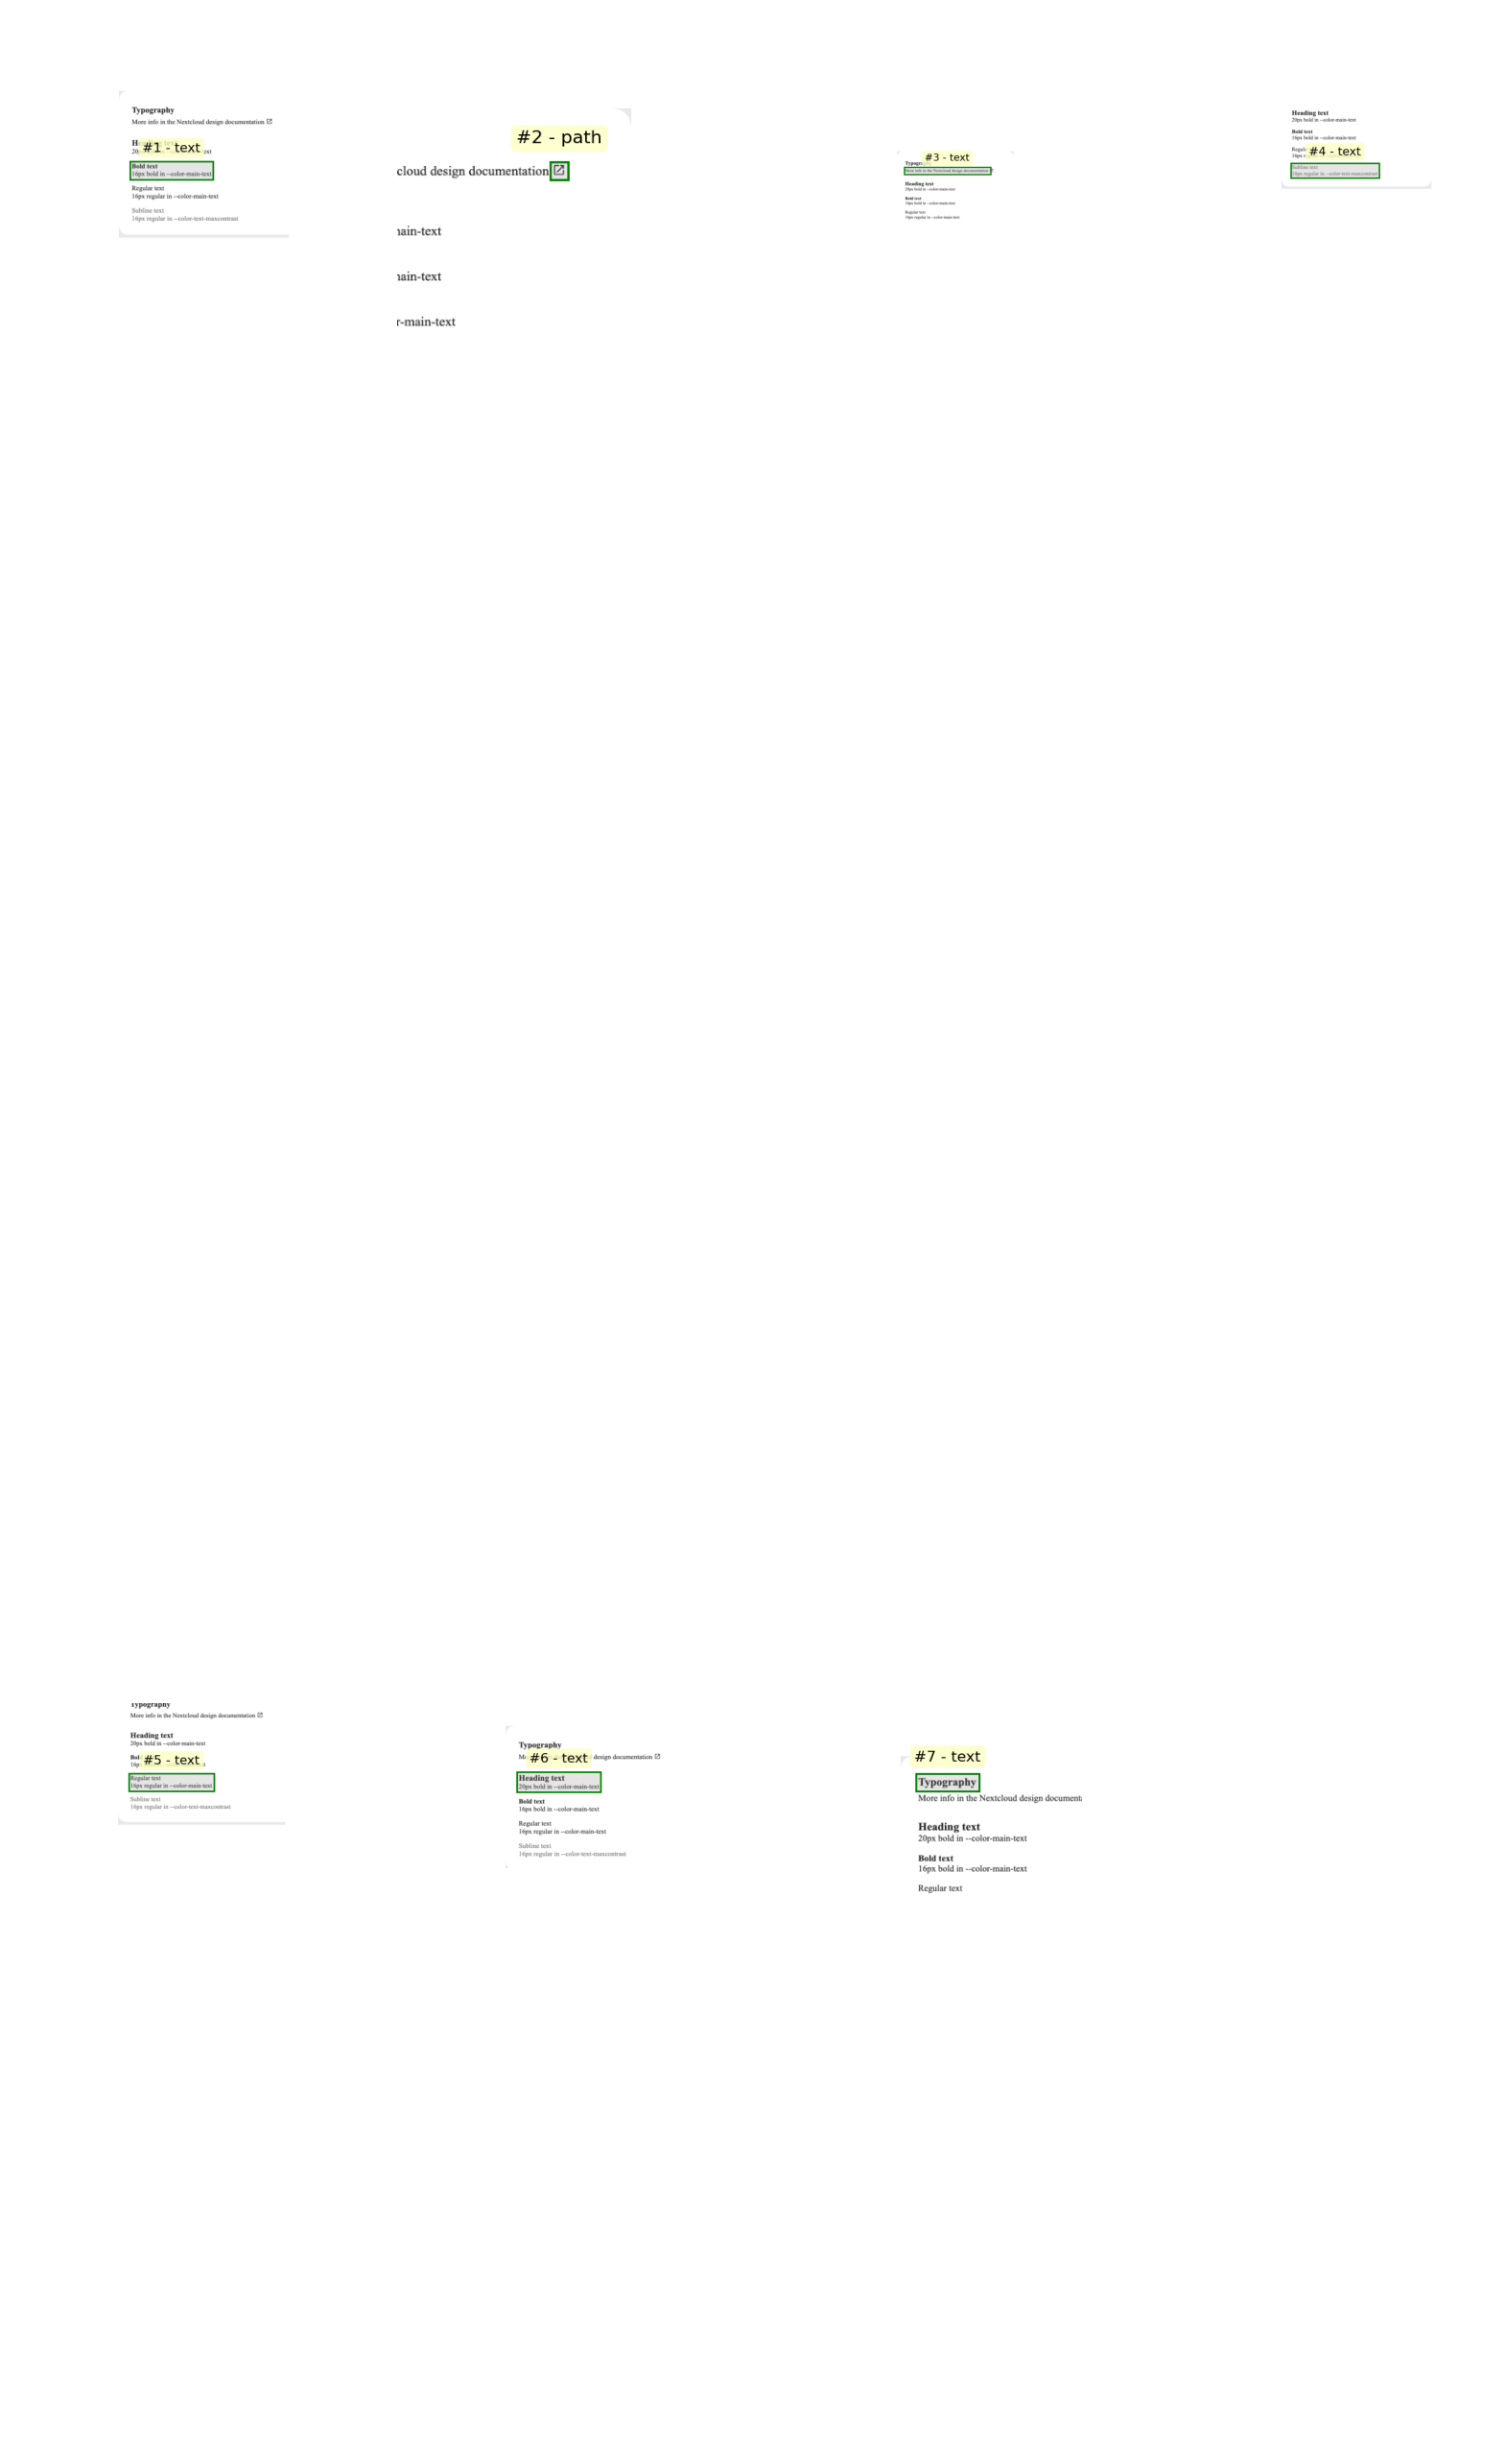

In [27]:
visualizations = list(ShapeVisualizer().visualize_bboxes_in_shape(playlist_shape))

img_per_row = 4

fig, axes = plt.subplots(math.ceil(len(visualizations) / img_per_row), img_per_row)

for i, ax in enumerate(axes.flat):
    if i < len(visualizations):
        ax.imshow(visualizations[i].image)
    ax.axis("off")

plt.show()

In [28]:
hierarchy_visualizer = InteractiveHierarchyVisualizer()
hierarchy_visualizer.inject_hierarchy_visualization(hierarchy)

svg = playlist_shape.to_svg()
hierarchy_visualizer.inject_stylesheet(svg.dom.getroot())
svg.to_file("hierarchy.svg")